<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.io
from scipy.signal import find_peaks
import scipy.signal as signal


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

E:\Apps\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# Set data folder path
DATA_FOLDER = 'D:\\NUS\\semester 2\\Course 3\\CA\\MAREA_dataset'
ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject Data_txt format')
PROCESSED_FOLDER = os.path.join(DATA_FOLDER, 'Processed_data')


# Define Activity Labels
indoor_label = ['tread_flat_walk_start',
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end'
                ]

outdoor_label = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

indoor_time_df = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                             , names=indoor_label)

outdoor_time_df = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                              , names=outdoor_label)

indoor_time_df["subject"] = ["Sub" + str(i) for i in range(1, 12)]
outdoor_time_df["subject"] = ["Sub" + str(j) for j in range(12, 21)]

In [ ]:
indoor_time_df

In [ ]:
outdoor_time_df

In [ ]:
pos_list = ['LF', 'RF', 'Waist', 'Wrist']
sub_list = ['Sub' + str(i) for i in range(1, 21)]
column_names = ['accX_LF', 'accY_LF', 'accZ_LF','accX_RF', 'accY_RF', 'accZ_RF', 'accX_Waist', 'accY_Waist', 'accZ_Waist','accX_Wrist', 'accY_Wrist', 'accZ_Wrist']

In [ ]:
#purposely exclude subject 4 first as missing data -- dont know how to deal with missing data for signal
sub_list.remove('Sub4')
print(sub_list)

In [ ]:
df = pd.DataFrame()
for sub in sub_list:
    lf_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    rf_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    waist_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    wrist_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    sub_df = pd.concat([lf_df, rf_df, waist_df, wrist_df], axis=1)
    sub_df.columns = column_names

    sub_df = sub_df.copy()
    n = int(sub[3:])
    if n > 11:
        sub_row = outdoor_time_df[outdoor_time_df['subject'] == sub]
        tmp = sub_row.iloc[0]
        sub_df.loc[0:tmp['outdoor_walk_end'], 'label'] = 'outdoor_walk'
        sub_df.loc[tmp['outdoor_walk_end']: tmp['outdoor_run_end'], 'label'] = 'outdoor_run'
    else:
        sub_row = indoor_time_df[indoor_time_df['subject'] == sub]
        tmp = sub_row.iloc[0]
        sub_df.loc[0:tmp['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
        sub_df.loc[tmp['tread_flat_walk_end']: tmp['tread_flat_run_end'],'label'] = 'tread_flat_run'
        sub_df.loc[tmp['tread_flat_run_end']: tmp['tread_slope_walk_start'], 'label'] = 'rest'
        sub_df.loc[tmp['tread_slope_walk_start']: tmp['tread_slope_walk_end'],'label'] = 'tread_slope_walk'
        sub_df.loc[tmp['tread_slope_walk_end']: tmp['indoor_flat_walk_start'], 'label'] = 'rest'
        sub_df.loc[tmp['indoor_flat_walk_start']: tmp['indoor_flat_walk_end'],'label'] = 'indoor_flat_walk'
        sub_df.loc[tmp['indoor_flat_walk_end']: tmp['indoor_flat_run_end'],'label'] = 'indoor_flat_run'

    sub_df['subject'] = sub
    df = df.append(sub_df)
    print(df.shape)

In [ ]:
df.head(5)

Preprocessing Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pywt
import pandas as pd
import time
from sklearn.metrics import confusion_matrix
from warnings import filterwarnings # Avoid training warning message in MLPClassifier
filterwarnings('ignore')

In [ ]:
def PreprocessingSignal(df, label, subject, feature, window, waveletname, waveletlevel, threshold):
    df = df.loc[(df['label'] == label) & (df['subject'] == subject)]
    
    #wavelet transform
    signal_orig = df[feature].values
    coeffs_orig = pywt.wavedec(signal_orig, waveletname, level=waveletlevel)
    coeffs_filter = coeffs_orig.copy()
    for i in range(1, len(coeffs_orig)):
        coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold*max(coeffs_orig[i]))
    signal_denoised = pywt.waverec(coeffs_filter, waveletname) 
    
    #cut signal into windows
    to_process_df = pd.DataFrame(signal_denoised)
    min_index = min(to_process_df.index)
    max_index = max(to_process_df.index)
    
    index_every_Xs_w_overlap = range(min_index, max_index+1, int(window/2))
    index_list = index_every_Xs_w_overlap
    windowed_selected_chunk_array = []
    for index in index_list:
        windowed_selected_chunk = to_process_df[0].iloc[index:index+window] 
        if windowed_selected_chunk.shape[0] == window:
            windowed_selected_chunk_array.append(windowed_selected_chunk.values) #normalize_numpy_columns(windowed_selected_chunk.values))
            
    output_np_arr = np.array(windowed_selected_chunk_array)

    #split into train and test
    train_len = int(0.8*len(output_np_arr))
    train_X = output_np_arr[:train_len,:]
    test_X = output_np_arr[train_len:len(output_np_arr),:]
    
    train_y = list()
    for i in range(len(train_X)):
        train_y.append(label)
    train_y = np.asarray(train_y)
    
    test_y = list()
    for i in range(len(test_X)):
        test_y.append(label)
    test_y = np.asarray(test_y)
    
    return train_X, test_X, train_y, test_y

In [ ]:
#feature_list = column_names
indoor_activity = ['tread_slope_walk', 'tread_flat_walk', 'indoor_flat_run', 'indoor_flat_walk', 'tread_flat_run', 'rest']
outdoor_activity = ['outdoor_walk', 'outdoor_run']
indoor_sub = ['Sub1', 'Sub2', 'Sub3', 'Sub5', 'Sub6', 'Sub7', 'Sub8', 'Sub9', 'Sub10', 'Sub11',]
outdoor_sub = ['Sub12', 'Sub13', 'Sub14', 'Sub15', 'Sub16', 'Sub17', 'Sub18', 'Sub19', 'Sub20']

In [ ]:
def PrepareFeature(feature):
    train_X = pd.DataFrame()
    test_X = pd.DataFrame()
    #train_y = np.asarray(list())
    train_y = pd.DataFrame()
    #test_y = np.asarray(list())
    test_y = pd.DataFrame()

    for feature in [feature]:
        #indoor activity
        for sub in indoor_sub:
            for activity in indoor_activity:
                tr_x, ts_x, tr_y, ts_y = PreprocessingSignal(df, activity, sub, feature, 128*4, 'db4', 2, 0.8)
                train_X = train_X.append(pd.DataFrame(tr_x))
                test_X = test_X.append(pd.DataFrame(ts_x))
                train_y = train_y.append(pd.DataFrame(tr_y))
                #train_y = np.append(train_y,tr_y)
                test_y = test_y.append(pd.DataFrame(ts_y)) 
                #test_y = np.append(test_y,ts_y)

        #outdoor activity
        for sub in outdoor_sub:
            for activity in outdoor_activity:
                tr_x, ts_x, tr_y, ts_y = PreprocessingSignal(df, activity, sub, feature, 128*4, 'db4', 2, 0.8)

                train_X = train_X.append(pd.DataFrame(tr_x))
                test_X = test_X.append(pd.DataFrame(ts_x))
                train_y = train_y.append(pd.DataFrame(tr_y))
                #train_y = np.append(train_y,tr_y)
                test_y = test_y.append(pd.DataFrame(ts_y)) 
                #test_y = np.append(test_y,ts_y)
    
    return train_X, test_X, train_y, test_y

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accX_LF')
train_X.to_csv('train_accX_LF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accX_LF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X.shape

In [ ]:
train_y.shape

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accY_LF')
train_X.to_csv('train_accY_LF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accY_LF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accZ_LF')
train_X.to_csv('train_accZ_LF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accZ_LF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accX_RF')
train_X.to_csv('train_accX_RF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accX_RF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accY_RF')
train_X.to_csv('train_accY_RF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accY_RF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accZ_RF')
train_X.to_csv('train_accZ_RF.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accZ_RF.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accX_Waist')
train_X.to_csv('train_accX_Waist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accX_Waist.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accY_Waist')
train_X.to_csv('train_accY_Waist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accY_Waist.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accZ_Waist')
train_X.to_csv('train_accZ_Waist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accZ_Waist.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accX_Wrist')
train_X.to_csv('train_accX_Wrist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accX_Wrist.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accY_Wrist')
train_X.to_csv('train_accY_Wrist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accY_Wrist.txt', header=None, index=False, sep='\t')

In [ ]:
train_X, test_X, train_y, test_y = PrepareFeature('accZ_Wrist')
train_X.to_csv('train_accZ_Wrist.txt', header=None, index=False, sep='\t')
test_X.to_csv('test_accZ_Wrist.txt', header=None, index=False, sep='\t')

In [ ]:
train_y.shape

In [ ]:
pd.DataFrame(train_y).to_csv('train_y.txt', header=None, index=False, sep='\t')
pd.DataFrame(test_y).to_csv('test_y.txt', header=None, index=False, sep='\t')

In [1]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [2]:
def load_group(filenames):
    loaded = list()
    for name in filenames:
        data = load_file(name)
        loaded.append(data)
    
    loaded = np.dstack(loaded)
    return loaded

In [3]:
def load_dataset_group(group):
    if group == 'train':
        filenames = ['train_accX_LF.txt','train_accY_LF.txt','train_accZ_LF.txt',
                    'train_accX_RF.txt','train_accY_RF.txt','train_accZ_RF.txt',
                    'train_accX_Waist.txt','train_accY_Waist.txt','train_accZ_Waist.txt',
                    'train_accX_Wrist.txt','train_accY_Wrist.txt','train_accZ_Wrist.txt']
        X = load_group(filenames)
        y = load_file('train_y.txt')
    else:
        filenames = ['test_accX_LF.txt','test_accY_LF.txt','test_accZ_LF.txt',
                    'test_accX_RF.txt','test_accY_RF.txt','test_accZ_RF.txt',
                    'test_accX_Waist.txt','test_accY_Waist.txt','test_accZ_Waist.txt',
                    'test_accX_Wrist.txt','test_accY_Wrist.txt','test_accZ_Wrist.txt']
        X = load_group(filenames)
        y = load_file('test_y.txt')
    return X,y

In [4]:
def load_dataset():
    train_X, train_y = load_dataset_group('train')
    test_X, test_y = load_dataset_group('test')
    return train_X, train_y, test_X, test_y

In [7]:
train_X, train_y, test_X, test_y = load_dataset()

In [8]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(train_X.shape[1])
print(train_X.shape[2])
print(train_y.shape[1])

(9462, 512, 12)
(9462, 1)
(2408, 512, 12)
(2408, 1)
512
12
1


In [9]:
from keras.utils import to_categorical
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [10]:
train_y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
test_y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(train_X.shape[1])
print(train_X.shape[2])
print(train_y.shape[1])

(9462, 512, 12)
(9462, 8)
(2408, 512, 12)
(2408, 8)
512
12
8


Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger

In [17]:
verbose, epochs, batch_size = 2, 20, 64
n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               45200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
Total params: 56,108
Trainable params: 56,108
Non-trainable params: 0
_________________________________________________________________


In [18]:
modelname = 'v1'
filepath        = os.path.join(modelname + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(modelname +'.csv'))
callbacks_list  = [checkpoint,csv_logger]

In [19]:
model.fit(train_X, train_y, 
          validation_data=(test_X, test_y), 
          epochs=epochs, batch_size=batch_size, 
          verbose=verbose, callbacks=callbacks_list)

Train on 9462 samples, validate on 2408 samples
Epoch 1/20
 - 264s - loss: 1.5458 - acc: 0.3939 - val_loss: 1.1940 - val_acc: 0.6038
Epoch 2/20
 - 267s - loss: 0.9461 - acc: 0.6159 - val_loss: 1.0790 - val_acc: 0.6819
Epoch 3/20
 - 273s - loss: 0.9330 - acc: 0.6245 - val_loss: 0.9230 - val_acc: 0.7321
Epoch 4/20
 - 270s - loss: 0.6609 - acc: 0.7420 - val_loss: 0.8921 - val_acc: 0.7309
Epoch 5/20
 - 271s - loss: 0.5429 - acc: 0.7999 - val_loss: 0.8429 - val_acc: 0.7596
Epoch 6/20
 - 272s - loss: 0.4895 - acc: 0.8273 - val_loss: 0.7139 - val_acc: 0.7895
Epoch 7/20
 - 272s - loss: 0.4263 - acc: 0.8524 - val_loss: 0.8319 - val_acc: 0.7741
Epoch 8/20
 - 279s - loss: 0.3600 - acc: 0.8808 - val_loss: 0.8367 - val_acc: 0.7878
Epoch 9/20
 - 278s - loss: 0.3288 - acc: 0.8903 - val_loss: 0.7849 - val_acc: 0.8094
Epoch 10/20
 - 281s - loss: 0.2926 - acc: 0.9029 - val_loss: 0.6956 - val_acc: 0.8131
Epoch 11/20
 - 282s - loss: 0.3429 - acc: 0.8818 - val_loss: 0.7741 - val_acc: 0.8044
Epoch 12/20
 - 

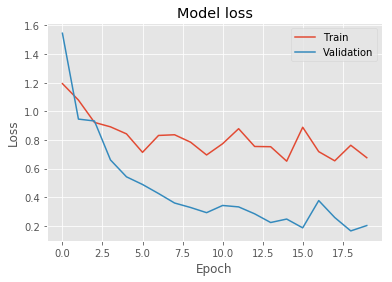

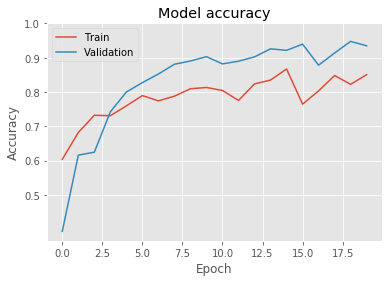

In [20]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.plot(records['val_loss'])
plt.plot(records['loss'])
#plt.yticks([0.00,0.2,0.40,0.60,0.80])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.figure()
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.5,0.6,0.7,0.8,0.9,1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [32]:
import sklearn.metrics as metrics
predicts = model.predict(test_X)
predicts = np.argmax(predicts, axis=1)

label = np.argmax(test_y, axis=1)

labelname = ['rest', 'tread_slope_walk', 'tread_flat_walk', 'tread_flat_run', 'indoor_flat_walk', 'indoor_flat_run', 'outdoor_walk', 'outdoor_run']

predictScore = metrics.accuracy_score(label, predicts)
confusion = metrics.confusion_matrix(label, predicts)
classification_report = metrics.classification_report(label, predicts, target_names=labelname, digits=4)

print("Best accuracy (on validation dataset): %.2f%%" % (predictScore * 100))
print(confusion)
print("Classification Report:")
print(classification_report)

Best accuracy (on validation dataset): 85.05%
[[268  82  11   0  43   0   1   0]
 [ 19 592   6   0  24   0   0   0]
 [  0   3 394  11   4   4  34  27]
 [  1   0   3 163   0  20   0   0]
 [  3  18  13   0 145   1   0   0]
 [  0   3   5   0   5 172   2   0]
 [  0   0   0   0   0   0 186   1]
 [  0   0   2   1   0   0  13 128]]
Classification Report:
                  precision    recall  f1-score   support

            rest     0.9210    0.6617    0.7701       405
tread_slope_walk     0.8481    0.9236    0.8842       641
 tread_flat_walk     0.9078    0.8260    0.8650       477
  tread_flat_run     0.9314    0.8717    0.9006       187
indoor_flat_walk     0.6561    0.8056    0.7232       180
 indoor_flat_run     0.8731    0.9198    0.8958       187
    outdoor_walk     0.7881    0.9947    0.8794       187
     outdoor_run     0.8205    0.8889    0.8533       144

        accuracy                         0.8505      2408
       macro avg     0.8433    0.8615    0.8465      2408
    weight